<a href="https://colab.research.google.com/github/Des-PM/DA/blob/main/FraudDetection_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE  
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from itertools import combinations
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import recall_score, make_scorer


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay


%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



## Data Sourcing

In [ ]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle 
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download shashwatwork/dataco-smart-supply-chain-for-big-data-analysis
!unzip /content/dataco-smart-supply-chain-for-big-data-analysis.zip

 35% 9.00M/25.7M [00:00<00:00, 37.1MB/s]
100% 25.7M/25.7M [00:00<00:00, 83.5MB/s]
Archive:  /content/dataco-smart-supply-chain-for-big-data-analysis.zip
  inflating: DataCoSupplyChainDataset.csv  
  inflating: DescriptionDataCoSupplyChain.csv  
  inflating: tokenized_access_logs.csv  


In [ ]:
df = pd.read_csv('/content/DataCoSupplyChainDataset.csv',encoding='latin-1')

## Data Cleaning: Data Extraction, Transformation and Cleaning

In [ ]:
# check NaN values
null_columns = df.columns[df.isna().any()] 
# printing column names containing NaN
print('Columns with NaN values are:' , null_columns)

Columns with NaN values are: Index(['Customer Lname', 'Customer Zipcode', 'Order Zipcode',
       'Product Description'],
      dtype='object')


In [ ]:
# removing the coumns having NaN values
df = df.drop(columns = null_columns, axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

#### Because we will identify customers/departments by their CustomerId/DepartmentId there is no need for the "Customer Lname" "Customer Fname" and "Department Name" columns.

In [ ]:
print(pd.unique(df['Product Status'])) # only contains zeros. no other unique values
# below are the columns in the data which are irrelevant. It contains no information 
irrelevant_info_columns = ["Customer Email", "Customer Fname", 
                          "Customer Password", "Department Name", "Product Image", "Product Status", "Customer Street", "shipping date (DateOrders)", "order date (DateOrders)"]

[0]


In [ ]:
df = df.drop(columns = irrelevant_info_columns, axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Id                    180519 non-null  int64  
 12  Customer Segment              

In [ ]:
def check_duplicate_columns(dataframe_test):
    columns_names = []
    
    for ii in list(combinations(dataframe_test.columns, 2)):
        if np.all(dataframe_test[ii[0]] == dataframe_test[ii[1]]):
            columns_names.append(ii)
            print("{} and {} are the same".format(*ii))
    
    return columns_names

                
redundancies = check_duplicate_columns(df)

Benefit per order and Order Profit Per Order are the same
Sales per customer and Order Item Total are the same
Category Id and Product Category Id are the same
Customer Id and Order Customer Id are the same
Order Item Cardprod Id and Product Card Id are the same
Order Item Product Price and Product Price are the same


Hence, we are removing one of the columns which are exactly the same. The removed columns are
**Order Profit Per Order, Order Item Total, Product Category Id, Order Customer Id, Order Item Cardprod Id, Order Item Product Price**

In [ ]:
duplicate_cols_to_remove = ["Order Profit Per Order", "Order Item Total", "Product Category Id", 
                            "Order Customer Id", "Order Item Cardprod Id", "Order Item Product Price"]
df = df.drop(columns = duplicate_cols_to_remove, axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Id                    180519 non-null  int64  
 12  Customer Segment              

                     0
CANCELED          3692
CLOSED           19616
COMPLETE         59491
ON_HOLD           9804
PAYMENT_REVIEW    1893
PENDING          20227
PENDING_PAYMENT  39832
PROCESSING       21902
SUSPECTED_FRAUD   4062
['CANCELED' 'CLOSED' 'COMPLETE' 'ON_HOLD' 'PAYMENT_REVIEW' 'PENDING'
 'PENDING_PAYMENT' 'PROCESSING' 'SUSPECTED_FRAUD'] [ 3692 19616 59491  9804  1893 20227 39832 21902  4062]


([<matplotlib.patches.Wedge at 0x7fd50a849970>,
 [Text(1.0977301846479284, 0.07062890139896982, 'CANCELED'),
  Text(0.9807828709815739, 0.49806120104776447, 'CLOSED'),
  Text(-0.29954403608977603, 1.0584296719400148, 'COMPLETE'),
  Text(-1.095641260962441, 0.09782753843694757, 'ON_HOLD'),
  Text(-1.0927956736438185, -0.12568856616794197, 'PAYMENT_REVIEW'),
  Text(-0.9656205515140237, -0.5268557207564067, 'PENDING'),
  Text(-0.02872151174594294, -1.0996249700525302, 'PENDING_PAYMENT'),
  Text(0.9532064688139192, -0.5489967466308876, 'PROCESSING'),
  Text(1.097252635755152, -0.0776959029059588, 'SUSPECTED_FRAUD')],
 [Text(0.5987619188988699, 0.03852485530852899, '2.05%'),
  Text(0.5349724750808584, 0.2716697460260533, '10.87%'),
  Text(-0.1633876560489687, 0.5773252756036443, '32.96%'),
  Text(-0.5976225059795132, 0.0533604755110623, '5.43%'),
  Text(-0.5960703674420827, -0.06855739972796834, '1.05%'),
  Text(-0.5267021190076492, -0.28737584768531277, '11.20%'),
  Text(-0.015666279134150

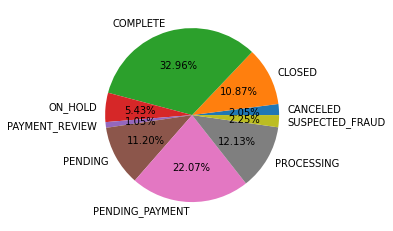

In [ ]:
subj_labels, subj_counts = np.unique(df['Order Status'], return_counts = True)
print(pd.DataFrame(subj_counts, subj_labels))

print(subj_labels, subj_counts)

plt.pie(subj_counts, labels = subj_labels, autopct = '%.2f%%')

### Using Label encoder all the column with datatype as object is been transformed
**Delivery Status, Category Name, Customer City, Customer Country, Customer Segment, Customer State, Market, Order City, Order Country, Order Region, Order State, Product Name, Shipping Mode, Type**

In [ ]:
le = preprocessing.LabelEncoder()
df['Delivery Status'] = le.fit_transform(df['Delivery Status'])
df['Category Name'] = le.fit_transform(df['Category Name'])
df['Customer City'] = le.fit_transform(df['Customer City'])
df['Customer Country'] = le.fit_transform(df['Customer Country'])
df['Customer Segment'] = le.fit_transform(df['Customer Segment'])
df['Customer State'] = le.fit_transform(df['Customer State'])
df['Market'] = le.fit_transform(df['Market'])
df['Order City'] = le.fit_transform(df['Order City'])
df['Order Country'] = le.fit_transform(df['Order Country'])
df['Order Region'] = le.fit_transform(df['Order Region'])
df['Order State'] = le.fit_transform(df['Order State'])
df['Product Name'] = le.fit_transform(df['Product Name'])
df['Shipping Mode'] = le.fit_transform(df['Shipping Mode'])
df['Type'] = le.fit_transform(df['Type'])

[0 1] [176457   4062]


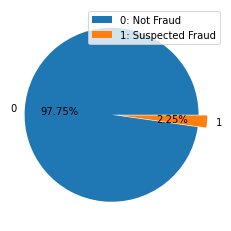

In [ ]:
df['Order Status'] = df['Order Status'].replace(['CANCELED', 'CLOSED', 'COMPLETE', 'ON_HOLD', 'PAYMENT_REVIEW', 'PENDING',
 'PENDING_PAYMENT', 'PROCESSING', 'SUSPECTED_FRAUD'],
                                        [0, 0, 0, 0, 0, 0, 0, 0, 1])
new_subj_labels, new_subj_counts = np.unique(df['Order Status'], return_counts = True)
print(new_subj_labels, new_subj_counts)
myexplode = [0.05, 0.05]
plt.pie(new_subj_counts, labels = new_subj_labels, explode = myexplode, autopct = '%.2f%%')
plt.legend(['0: Not Fraud', '1: Suspected Fraud'])

In [ ]:
X = df.drop('Order Status', axis=1)
Y = df['Order Status']
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  int64  
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  int64  
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  int64  
 9   Customer City                  180519 non-null  int64  
 10  Customer Country               180519 non-null  int64  
 11  Customer Id                    180519 non-null  int64  
 12  Customer Segment              

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size =0.3, random_state = 7)


In [ ]:
# Normalizing numerical features so that each feature has mean 0 and variance 1

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Function for Confusion matrix and ROC curve

In [ ]:
def ML_model_training_testing(ML_model, X_train, Y_train, X_test, Y_test):
    CrossValid_scores = cross_validate(ML_model, X_train, Y_train, cv=10, scoring='accuracy', return_train_score=True)

    train_accuracy = np.mean(CrossValid_scores['train_score'])
    cross_val_accuracy = np.mean(CrossValid_scores['test_score'])

    print(f"Train accuracy = {train_accuracy*100:.4f}")
    print(f"Cross validation accuracy= {cross_val_accuracy*100:.4f}")

    # Train SVM classifier on the labelled dataset
    ML_model.fit(X_train, Y_train)

    #To plot confusion matrix and finding out precision,recall,accuracy and f1 score.
    y_predict = ML_model.predict(X_test)
    con_mat = confusion_matrix(Y_test, y_predict)
    print("Confusion matrix")
    print(con_mat)
    pre = precision_score(Y_test, y_predict)
    rec = recall_score(Y_test, y_predict)
    f1 = f1_score(Y_test, y_predict)
    accu = accuracy_score(Y_test, y_predict)
    print(f"Precision = {pre*100}")
    print(f"Accuracy = {accu*100}")
    print(f"F1 Score = {f1*100}")
    print(f"Recall = {rec*100}")
    
    return ML_model, y_predict

# Function to plot ROC curve
def plotROCcurve(y_true, y_predict, classifier_name=""):
    fpr, tpr, thresh = roc_curve(y_true, y_predict)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr).plot(color = "blue", label = f"ROC curve (area = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color = "red", lw = 2, linestyle = "--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve of " + classifier_name +  " Classifier")
    plt.legend(loc="lower right")
     

### Random Forest 

Random Forest Baseline model

In [ ]:
# Create an instance of the decision tree classifier
clf_rfc = RandomForestClassifier()

# Train the classifier on the training data
clf_rfc.fit(X_train, Y_train)

# Make predictions on the test set
y_predict_rfc = clf_rfc.predict(X_test)

# Evaluate the performance of the model
recall = recall_score(Y_test, y_predict_rfc)
print("Recall of the RFC classifier: ", recall )

# Print the model parameters
print("Model parameters: ", clf_rfc.get_params())


Recall of the RFC classifier:  0.7958847736625514
Model parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### Random Forest Hypereparameter Tuning

In [ ]:
# Define the Random Forest classifier
rf = RandomForestClassifier()

# Define the parameters for the GridSearchCV
parameters = {'n_estimators': [50,100,150,250,300,350],
              'min_samples_split': [2, 6, 10],
              'min_samples_leaf': [1, 3, 4],
              'max_features': ['auto'],
              'max_depth':[int(x) for x in np.linspace(10, 120, num = 12)]}

# Create the GridSearchCV object
grid_search = GridSearchCV(rf, parameters, scoring='recall')

# fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train)

# print the best parameters and the best recall score
print("Best parameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)


# evaluate the model on the test set
y_pred = grid_search.predict(X_test)
test_recall = recall_score(Y_test, y_pred)
print("Test recall score: ", test_recall)

Best parameters:  {'max_depth': 120, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best recall score:  0.7695939321061881
Test recall score:  0.8518518518518519


In [ ]:
# Calculate the recall score
recall = recall_score(Y_test, y_pred)
print("Recall Score:", recall)

# Compare the training and test recall scores
train_recall = recall_score(Y_train, grid_search.predict(X_train))
print("Training Recall Score:", train_recall)

Recall Score: 0.8518518518518519
Training Recall Score: 1.0


### Random Forest With SMOTE

In [ ]:
# Implementing Random Forest Classifier
# Tuning the random forest parameter 'n_estimators' and implementing cross-validation using Grid Search
model = Pipeline([
        ('balancing', SMOTE(random_state = 101)),
        ('classification', RandomForestClassifier(criterion='entropy', max_features='auto', random_state=1) )
    ])
grid_param = {'classification__n_estimators': [100,150, 200, 250, 300],
              'min_samples_split': [2, 6, 10],
              'min_samples_leaf': [1, 3, 4],
              'max_depth':120} 
              
gd_sr = GridSearchCV(estimator=model, param_grid=grid_param, scoring='recall', cv=5)

gd_sr.fit(X_train, Y_train)

featimp = pd.Series(gd_sr.best_estimator_.named_steps["classification"].feature_importances_, index=list(X)).sort_values(ascending=False) # Getting feature importances list for the best model
print(featimp)

# print the best parameters and the best recall score
print("Best parameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_) # Mean cross-validated score of the best_estimator


# evaluate the model on the test set
y_pred = gd_sr.predict(X_test)
test_recall = recall_score(Y_test, y_pred)
print("Test recall score: ", test_recall)

Delivery Status                  0.437708
Type                             0.273321
Late_delivery_risk               0.119655
Days for shipping (real)         0.033609
Customer Segment                 0.012317
Shipping Mode                    0.010081
Order Item Profit Ratio          0.009783
Days for shipment (scheduled)    0.008944
Order Item Discount Rate         0.006864
Order Item Discount              0.005440
Customer Id                      0.005212
Order Item Quantity              0.005195
Latitude                         0.004675
Order City                       0.004639
Order State                      0.004617
Order Country                    0.004526
Longitude                        0.004267
Order Item Id                    0.004050
Order Id                         0.004028
Order Region                     0.003913
Department Id                    0.003699
Customer State                   0.003556
Customer City                    0.003550
Category Id                      0

In [ ]:
# Calculate the recall score
recall = recall_score(Y_test, y_pred)
print("Recall Score:", recall)

# Compare the training and test recall scores
train_recall = recall_score(Y_train, gd_sr.predict(X_train))
print("Training Recall Score:", train_recall)

Recall Score: 0.9275720164609054
Training Recall Score: 1.0


### Random Forest Confusion matrix and ROC

Train accuracy = 100.0000
Cross validation accuracy= 99.3440
Confusion matrix
[[52827   114]
 [  198  1017]]
Precision = 89.92042440318302
Accuracy = 99.42388654996677
F1 Score = 86.70076726342711
Recall = 83.7037037037037


<Figure size 432x288 with 0 Axes>

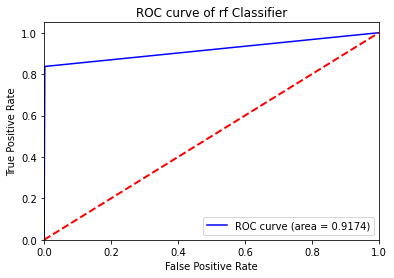

In [ ]:
clf_rf = RandomForestClassifier(n_estimators = 300, min_samples_leaf = 1, min_samples_split = 2, )
trained_ada_model, y_predict_rf = ML_model_training_testing(clf_rf, X_train, Y_train, X_test, Y_test)
plotROCcurve(Y_test, y_predict_rf, classifier_name="rf")


# **Recall scores of RFC model**

*   RFC Baseline model: 0.79
*   RFC Hyperparameter tuned model: 0.85
*   RFC SMOTE model: 0.67

# **Precision, Recall, Accuracy and F1 scores of RFC model**
*   Precision = 89.92
*   Accuracy = 99.42
*   F1 Score = 86.70
*   Recall = 83.70





##AdaBoost

### AdaBoost Baseline model

In [ ]:
# Initialize the AdaBoost classifier
ada = AdaBoostClassifier()

# Fit the classifier on the training data
ada.fit(X_train, Y_train)

# Make predictions on the test data
y_pred = ada.predict(X_test)

# Compute the recall score
recall = recall_score(Y_test, y_pred)

print("Recall of the ADA classifier:", recall)

# Print the parameters
print("Model parameters: ", ada.get_params())


Recall of the ADA classifier: 0.6625514403292181
Model parameters:  {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}


###AdaBoost Hyperparameter tuning

In [ ]:
# Define the AdaBoost classifier
ada = AdaBoostClassifier()

# Define the parameters for the GridSearchCV
parameters = {'n_estimators': [50, 100, 150], 'learning_rate': [0.1, 0.5, 1]}

# Define the recall scoring method
recall_scorer = make_scorer(recall_score)

# Perform the GridSearchCV
grid_search = GridSearchCV(ada, parameters, scoring=recall_scorer)
grid_search.fit(X_train, Y_train)

# Print the best parameters and the best recall score
print("Best parameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

# Fit to the data
ada.fit(X_train, Y_train)

# Predict the labels of the test data
y_pred = ada.predict(X_test)

# Print the recall score
print("Recall Score:", recall_score(Y_test, y_pred))

Best parameters:  {'learning_rate': 0.1, 'n_estimators': 50}
Best recall score:  0.793110103906515
Recall Score: 0.6617283950617284


In [ ]:
# Make predictions on the test data
y_pred = ada.predict(X_test)

# Calculate the recall score
recall = recall_score(Y_test, y_pred)
print("Recall Score:", recall)

# Compare the training and test recall scores
train_recall = recall_score(Y_train, ada.predict(X_train))
print("Training Recall Score:", train_recall)

Recall Score: 0.6617283950617284
Training Recall Score: 0.684931506849315


### AdaBoost with SMOTE

In [ ]:
# Implementing Adaboost Classifier
# Tuning the parameter 'n_estimators' and implementing cross-validation using Grid Search
model = Pipeline([
        ('balancing', SMOTE(random_state = 101)),
        ('classification', AdaBoostClassifier(random_state=1))
    ])
grid_param = {'classification__n_estimators': [50,100,150,200]}

ad_gd_sr = GridSearchCV(estimator=model, param_grid=grid_param, scoring='recall', cv=5)

ad_gd_sr.fit(X_train, Y_train)


featimp = pd.Series(ad_gd_sr.best_estimator_.named_steps["classification"].feature_importances_, index=list(X)).sort_values(ascending=False) # Getting feature importances list for the best model
print(featimp)

# print the best parameters and the best recall score
print("Best parameters: ", ad_gd_sr.best_params_)
print("Best recall score: ", ad_gd_sr.best_score_) # Mean cross-validated score of the best_estimator


# evaluate the model on the test set
y_pred = ad_gd_sr.predict(X_test)
test_recall = recall_score(Y_test, y_pred)
print("Test recall score: ", test_recall)

{'classification__n_estimators': 50}
0.9908685598002034
Customer Segment                 0.26
Days for shipping (real)         0.22
Order Item Quantity              0.12
Order Item Discount Rate         0.08
Order Item Profit Ratio          0.04
Sales                            0.04
Delivery Status                  0.04
Product Price                    0.04
Category Id                      0.02
Category Name                    0.02
Order Region                     0.02
Customer Id                      0.02
Customer State                   0.02
Latitude                         0.02
Product Name                     0.02
Order Item Id                    0.02
Order State                      0.00
Order Item Discount              0.00
Product Card Id                  0.00
Type                             0.00
Longitude                        0.00
Order Id                         0.00
Order Country                    0.00
Order City                       0.00
Market                          

In [ ]:
# Calculate the recall score
recall = recall_score(Y_test, y_pred)
print("Recall Score:", recall)

# Compare the training and test recall scores
train_recall = recall_score(Y_train, ad_gd_sr.predict(X_train))
print("Training Recall Score:", train_recall)

Recall Score: 0.9975308641975309
Training Recall Score: 0.9964875307341061


###AdaBoost Confusion matrix and ROC curve

Train accuracy = 98.1332
Cross validation accuracy= 97.9804
Confusion matrix
[[52156   785]
 [  233   982]]
Precision = 55.57441992076967
Accuracy = 98.12024521751975
F1 Score = 65.86183769282361
Recall = 80.82304526748972


<Figure size 432x288 with 0 Axes>

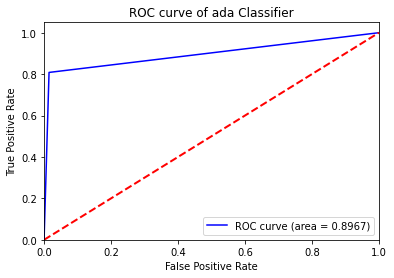

In [ ]:
clf_ada = AdaBoostClassifier(n_estimators = 50, learning_rate = 0.1)
trained_ada_model, y_predict_ada = ML_model_training_testing(clf_ada, X_train, Y_train, X_test, Y_test)
plotROCcurve(Y_test, y_predict_ada, classifier_name="ada")

# **Recall scores of AdaBoost model**

*   ADA Boost baseline model:0.66
*   ADA Boost Hyperparameter model:0.79
*   ADA Boost with SMOTE model:0.99

# **Precision, Recall, Accuracy and F1 scores of AdaBoost model**
*   Precision = 55.57
*   Accuracy = 98.12
*   F1 Score = 65.86
*   Recall = 80.82





##SUPPORT VECTOR CLASSIFIER

###SVC Baseline model

In [ ]:
# Initialize the SVC model
clf_svc = SVC()

# Traininig the classifier on the training data
clf_svc.fit(X_train, Y_train)

# Make predictions on the test set
y_predict_svc = clf_svc.predict(X_test)

# Evaluating the performance of the model
recall = recall_score(Y_test, y_predict_svc)
print("Recall of the SVC classifier: ", recall )

# Print the model parameters
print("Model parameters: ", clf_svc.get_params())

Recall of the SVC classifier:  0.297119341563786
Model parameters:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


###SVC Hyperparameter tuning

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['rbf','linear']}


# Create the SVC object
svc = SVC()

# Create the GridSearchCV object
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='recall')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Use the best parameters to create a new SVC object
svc = SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'])

# Fit the SVC object to the data
svc.fit(X_train, Y_train)

# Use the SVC object to predict the labels of the test data
y_pred = svc.predict(X_test)

# Print the recall score
print("Recall Score:", recall_score(Y_test, y_pred))

Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Score: 0.6122270526932445
Recall Score: 0.6419753086419753


In [ ]:
# Calculate the recall score
recall = recall_score(Y_test, y_pred)
print("Recall Score:", recall)

# Compare the training and test recall scores
train_recall = recall_score(Y_train, svc.predict(X_train))
print("Training Recall Score:", train_recall)

Recall Score: 0.6419753086419753
Training Recall Score: 0.8998946259220232


###SVC SMOTE

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {'C': [0.1,1,10], 'kernel': [ 'rbf','linear']}

# Create the SMOTE object
sm = SMOTE()
X_train, Y_train = sm.fit_resample(X_train, Y_train)

# Create the SVC object
svc = SVC()

# Create the GridSearchCV object
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='recall')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Use the best parameters to create a new SVC object
svc = SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'])

# Fit the SVC object to the data
svc.fit(X_train, Y_train)

# Use the SVC object to predict the labels of the test data
y_pred = svc.predict(X_test)

# Print the recall score
print("Recall Score:", recall_score(Y_test, y_pred))

Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Score: 1.0
Recall Score: 0.8098765432098766


In [ ]:
# Calculate the recall score
recall = recall_score(Y_test, y_pred)
print("Recall Score:", recall)

# Compare the training and test recall scores
train_recall = recall_score(Y_train, svc.predict(X_train))
print("Training Recall Score:", train_recall)

Recall Score: 0.8098765432098766
Training Recall Score: 1.0


###SVC Confusion matrix and ROC

Train accuracy = 99.5529
Cross validation accuracy= 98.3365
Confusion matrix
[[52511   430]
 [  435   780]]
Precision = 64.46280991735537
Accuracy = 98.40276239013221
F1 Score = 64.3298969072165
Recall = 64.19753086419753


<Figure size 432x288 with 0 Axes>

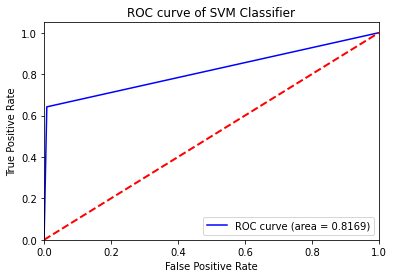

In [ ]:
clf_SVM = SVC(C = 10, kernel = 'rbf')
trained_SVM_model, y_predict_SVM = ML_model_training_testing(clf_SVM, X_train, Y_train, X_test, Y_test)
plotROCcurve(Y_test, y_predict_SVM, classifier_name="SVM")


# **Recall scores of SVC model**

*   SVC Baseline Model:O.29
*   SVC Hyperparamater tuned Model:0.61
*   SVC with SMOTE:0.80

# **Precision, Recall, Accuracy and F1 scores of SVC model**
*   Precision = 64.46
*   Accuracy = 98.40
*   F1 Score = 64.32
*   Recall = 64.19












##XG BOOST

###XG Boost Baseline model

In [ ]:
# Define the model
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, Y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model using recall score
recall = recall_score(Y_test, y_pred)
print("Recall score:", recall)

Recall score: 0.7300411522633745


##XG Boost Hyperparameter Tuning.

In [ ]:
# define the model
xgb_model = xgb.XGBClassifier()

# define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.3, 0.5],
    'n_estimators': [100, 200, 300]
}

# define the recall scoring metric
recall_scorer = make_scorer(recall_score)

# set up the GridSearchCV object
xgb_grid_search = GridSearchCV(xgb_model, param_grid, scoring=recall_scorer)

# fit the GridSearchCV object to the data
xgb_grid_search.fit(X_train, Y_train)

featimp = pd.Series(gd_sr.best_estimator_.named_steps["classification"].feature_importances_, index=list(X)).sort_values(ascending=False) # Getting feature importances list for the best model
print(featimp)
# print the best parameters and the best recall score
print("Best parameters: ", xgb_grid_search.best_params_)
print("Best recall score: ", xgb_grid_search.best_score_) # Mean cross-validated score of the best_estimator


# evaluate the model on the test set
y_pred = xgb_grid_search.predict(X_test)
test_recall = recall_score(Y_test, y_pred)
print("Test recall score: ", test_recall)

Delivery Status                  0.437708
Type                             0.273321
Late_delivery_risk               0.119655
Days for shipping (real)         0.033609
Customer Segment                 0.012317
Shipping Mode                    0.010081
Order Item Profit Ratio          0.009783
Days for shipment (scheduled)    0.008944
Order Item Discount Rate         0.006864
Order Item Discount              0.005440
Customer Id                      0.005212
Order Item Quantity              0.005195
Latitude                         0.004675
Order City                       0.004639
Order State                      0.004617
Order Country                    0.004526
Longitude                        0.004267
Order Item Id                    0.004050
Order Id                         0.004028
Order Region                     0.003913
Department Id                    0.003699
Customer State                   0.003556
Customer City                    0.003550
Category Id                      0

In [ ]:
# Calculate the recall score
recall = recall_score(Y_test, y_pred)
print("Recall Score:", recall)

# Compare the training and test recall scores
train_recall = recall_score(Y_train, xgb_grid_search.predict(X_train))
print("Training Recall Score:", train_recall)

Recall Score: 0.8880658436213992
Training Recall Score: 1.0


XG BOOST With SMOTE

In [ ]:
# oversample minority class using SMOTE
sm = SMOTE()
X_train, Y_train = sm.fit_resample(X_train, Y_train)

# define xgboost classifier
xgb_clf = xgb.XGBClassifier()

# define hyperparameter grid to search
param_grid = {'max_depth': [3, 5, 7],
              'learning_rate': [0.1, 0.3, 0.5],
              'n_estimators': [100, 200, 300]}

# define scoring metric as recall
scoring = {'Recall': 'recall'}

# perform grid search with cross-validation
xgb_grid = GridSearchCV(xgb_clf, param_grid, cv=5, scoring=scoring, refit='Recall')
xgb_grid.fit(X_train, Y_train)

# print best parameters and recall score
print("Best parameters: ", xgb_grid.best_params_)
print("Best recall score: ", xgb_grid.best_score_)

# make predictions on test set and evaluate recall score
y_pred = xgb_grid.predict(X_test)
test_recall = recall_score(Y_test, y_pred)
print("Test recall score: ", test_recall)

# Calculate the recall score
recall = recall_score(Y_test, y_pred)
print("Recall Score:", recall)

# Compare the training and test recall scores
train_recall = recall_score(Y_train, xgb_grid.predict(X_train))
print("Training Recall Score:", train_recall)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best recall score:  0.9857588147188601
Test recall score:  0.8724279835390947


In [ ]:
# Calculate the recall score
recall = recall_score(Y_test, y_pred)
print("Recall Score:", recall)

# Compare the training and test recall scores
train_recall = recall_score(Y_train, xgb_grid.predict(X_train))
print("Training Recall Score:", train_recall)

Recall Score: 0.8987654320987655
Training Recall Score: 1.0


###XGBoost Confusion matrix and ROC Curve

Train accuracy = 99.9936
Cross validation accuracy= 99.4183
Confusion matrix
[[52782   159]
 [  123  1092]]
Precision = 87.29016786570743
Accuracy = 99.47928207400842
F1 Score = 88.56447688564477
Recall = 89.87654320987654


<Figure size 432x288 with 0 Axes>

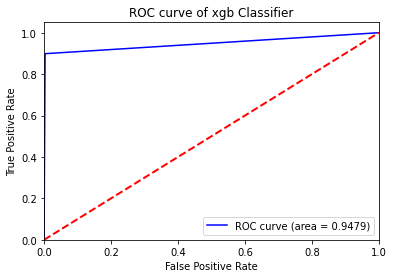

In [ ]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(n_estimators = 300, learning_rate = 0.1, max_depth = 7)
trained_ada_model, y_predict_ada = ML_model_training_testing(clf_xgb, X_train, Y_train, X_test, Y_test)
plotROCcurve(Y_test, y_predict_ada, classifier_name="xgb")


# **Recall scores of XGBoost model**

*   XG Boost Baseline Model:0.73
*   XG Boost Hyperparameter tuned Model: 0.88
*   XG Boost with SMOTE Model:0.98

# **Precision, Recall, Accuracy and F1 scores of XGBoost model**
*   Precision = 87.29
*   Accuracy = 99.47
*   F1 Score = 88.56
*   Recall = 89.87




###Conclusion

Adaboost model with SMOTE has a recall score of 0.99 with only few features. The test score and train score of 0.99 suggests that the model is performing well on both the training and test data making it a best model.


##AUC of classifiers without SMOTE
*  Random Forest ROC = 0.91
*  AdaBoost ROC = 0.89
*  XGBoost ROC = 0.94
*  SVM ROC = 0.81